<a href="https://colab.research.google.com/github/fravona2211/Berliving/blob/master/OSM_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# Install GDAL and Geopandas
!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
!pip install git+git://github.com/geopandas/geopandas.git --quiet
!pip install descartes --quiet
!pip install osmnx==0.14.1
!pip install folium

Reading package lists...
Building dependency tree...
Reading state information...
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
python3-rtree is already the newest version (0.8.3+ds-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.


In [ ]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import folium
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting Kreuzberg

/usr/local/lib/python3.6/dist-packages/osmnx/plot.py:96: UserWarning: the plot_shape function has been deprecated and will be removed in the next release, use gdf.plot() instead
  "the plot_shape function has been deprecated and will be removed in the next release, use gdf.plot() instead"


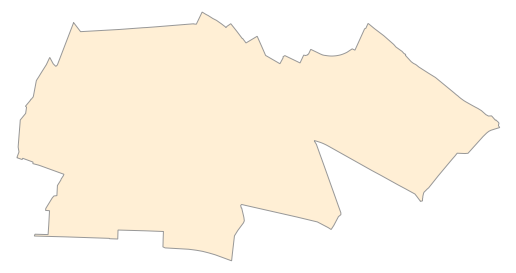

In [ ]:
city = ox.gdf_from_place('Kreuzberg, Berlin, Germany')
city_proj = ox.projection.project_gdf(city)
fig, ax = ox.plot_shape(city_proj, figsize=(9, 9), fc='papayawhip')

# Streets

Specifing the place

In [ ]:
place = "Kreuzberg, Berlin, Germany"

### Working with different street networks

Mapping the driving network

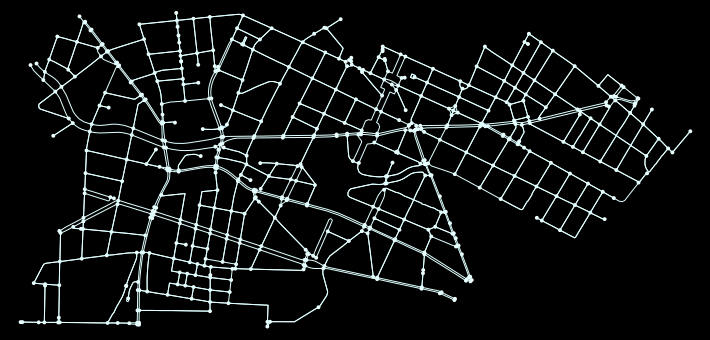

(<Figure size 1515.28x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc8b4dcb6d8>)

In [ ]:
graph_driving = ox.graph_from_place(place, network_type='drive')
ox.plot_graph(graph_driving, bgcolor= 'k', node_color = 'azure', edge_color = 'lightcyan')

Mapping the biking network

In [ ]:
graph_biking = ox.graph_from_place(place, network_type = 'bike')
ox.plot_graph(graph_biking, node_size = 30, node_color = 'darkseagreen')

TypeError: ignored

Comparing the ammount of streets for driving and biking against each other

In [ ]:
print("Driving: ", len(graph_driving))
print("Biking: ",len(graph_biking))

Taking a closer look at the streets for driving

In [ ]:
nodes, streets = ox.graph_to_gdfs(graph_driving)

In [ ]:
streets.head()

What's the distrubition over different street types?

In [ ]:
street_types = pd.DataFrame(streets["highway"].apply(pd.Series)[0].value_counts().reset_index())
street_types.columns = ["type", "count"]

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(y="type", x="count", data=street_types, ax=ax)
plt.tight_layout()
plt.savefig("barchart.png")

## How far can you walk within 5, 10, 15, 20 and 25 minutes?




### Setup

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
%matplotlib inline
ox.config(log_console=True, use_cache=True)


### Mapping

In [ ]:
# configure the place, network type, trip times, and travel speed
network_type = 'walk'
trip_times = [5, 10, 15, 20, 25] #in minutes
travel_speed = 4.5 #walking speed in km/hour

In [ ]:
# download the street network
G = ox.graph_from_place(place, network_type=network_type)

In [ ]:
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.get_nearest_node(G, (y[0], x[0]))
G = ox.project_graph(G)

In [ ]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [ ]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)

In [ ]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2,
                        bgcolor='k', edge_linewidth=0.2, edge_color='#999999')

# Point of Interest 


Creating an object storing all amnities found in place

In [ ]:
amen = ox.pois_from_place(place, tags={'amenity':True})
amen.head()

/usr/local/lib/python3.6/dist-packages/osmnx/pois.py:370: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf = gdf.loc[gdf["geometry"].centroid.within(polygon)]


,osmid,geometry,amenity,religion,wheelchair,element_type,name,phone,website,addr:city,addr:country,addr:housenumber,addr:postcode,addr:street,addr:suburb,cuisine,diet:vegan,opening_hours,contact:phone,contact:website,sausage,wikidata,wikipedia,brand,brand:wikidata,brand:wikipedia,cmt,operator,ref,collection_times,dispensing,healthcare,check_date,check_date:collection_times,colour,drive_through,material,support,diet:vegetarian,outdoor_seating,...,building:use,building:min_level,isced:level,organisation,building:part,fuel:e10,country,diplomatic,embassy,name:la,roof:material,name:etymology:wikidata,amenity_1,subdenomination,building:material,roof:colour,height,landuse,hgv,school,protect_class,year_of_construction,building:demolished,tenant,natural,capacity:parent,capacity:women,noaddress,building:levels:underground,reg_name,room,automated,polling_station,recycling:paper,recycling:plastic,research_institution,payment:contactless,catering,cargo_bike,operator:short
29209127,29209127,POINT (13.39038 52.49518),place_of_worship,christian,limited,node,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30012753,30012753,POINT (13.42919 52.49404),arts_centre,NaN,yes,node,Umspannwerk,+493066068444,http://www.umspannwerk-kreuzberg.de/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30020303,30020303,POINT (13.39398 52.49071),restaurant,NaN,no,node,Tibet Haus,+49306948948,NaN,Berlin,DE,19,10961,Zossener Straße,Kreuzberg,tibetan,yes,12:00-24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30022140,30022140,POINT (13.38773 52.49356),fast_food,NaN,yes,node,Curry 36,NaN,NaN,Berlin,DE,36,10961,Mehringdamm,Kreuzberg,sausage,NaN,Mo-Su 09:00-05:00,+49 30 2580088336,https://curry36.de/,curry,Q1144909,de:Curry 36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68363395,68363395,POINT (13.44978 52.49717),fuel,NaN,NaN,node,Aral,+49 30 61286590,https://www.aral.de/tankstelle/berlin/vor_dem_...,Berlin,DE,2,10997,Vor dem Schlesischen Tor,Kreuzberg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Aral,Q565734,en:Aral AG,ref=tankstellennumber found on the reciept,Yvonne Hoffmann,0110346129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
nightlife = ox.pois_from_place(place, tags={'amenity':['bar', 'biergarten', 'hookah_lounge', 'nightclub', 'stripclubs', 'swingerclubs']}); nightlife

What kind of amenities are there?

In [ ]:
set(amen['amenity'])

Count how many amenities of each type exist.

In [ ]:
counts_amen = amen['amenity'].value_counts(); counts_amen

## Cafes

In [ ]:
cafe = ox.pois_from_place(place, tags={'amenity':'cafe'})

In [ ]:
cafe.head()

In [ ]:
columns =['name','wheelchair', 'opening_hours', 'addr:street', 'addr:city','addr:postcode']
cafe[columns].head()

In [ ]:
len(cafe)